In [1]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np

x_min, x_max = -1, 1
y_min, y_max = 0, 2
N_iter = 20
x_0 = 1

fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = xdata**4
plt.plot(xdata, ydata)
# plt.title('Сходимость метода Ньютона для y = x**4')
plt.xlabel('x')
plt.ylabel('f(x) = x**4')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [x_0**4]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = 2/3*x
        yield x

def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = x**4
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [2]:
ani

Text(0, 0.5, 'Логарифм потерь')

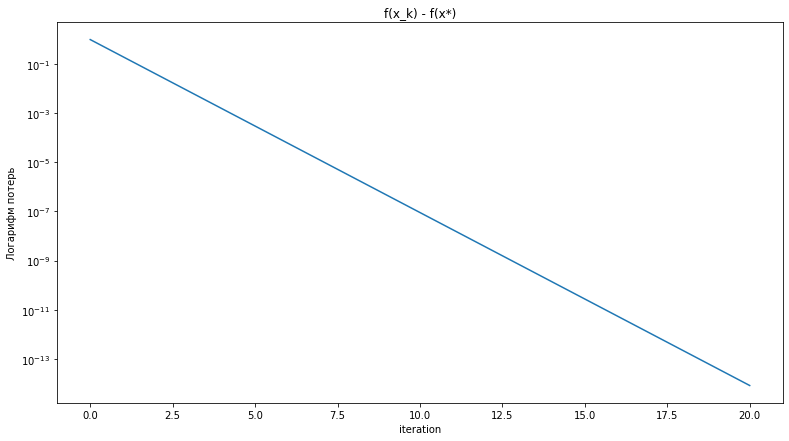

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
plt.semilogy(ydata)
plt.title('f(x_k) - f(x*)')
plt.xlabel('iteration')
plt.ylabel('Логарифм потерь')

In [4]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np

x_min, x_max = -3, 3
y_min, y_max = 1, 3
N_iter = 4
x_0 = 0.999+0.01



fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = np.sqrt(1 + xdata**2)
plt.plot(xdata, ydata)
plt.title('Сходимость метода Ньютона для y = sqrt(1 + x**2) ')
plt.xlabel('x')
plt.ylabel('f(x)')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [np.sqrt(1 + x_0**2)]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = -x**3
        yield x


def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = np.sqrt(1 + x**2)
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [5]:
ani

Text(0, 0.5, 'Логарифм потерь')

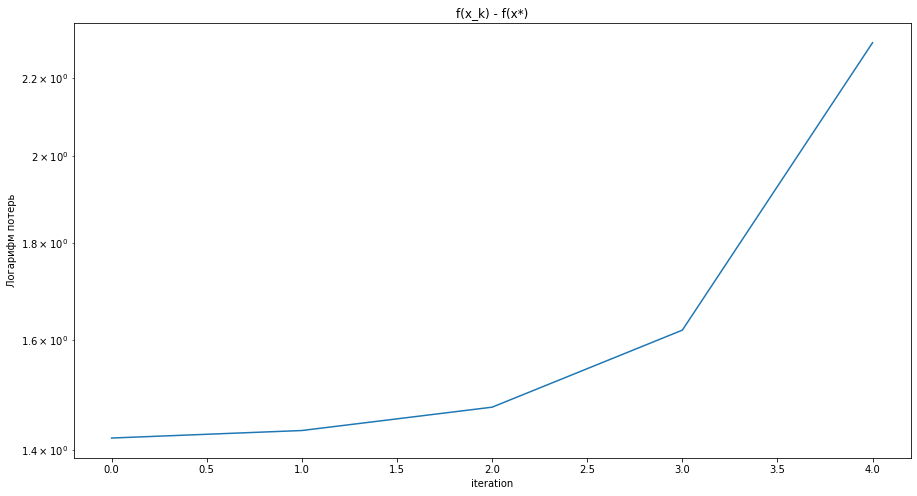

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
plt.semilogy(ydata)
plt.title('f(x_k) - f(x*)')
plt.xlabel('iteration')
plt.ylabel('Логарифм потерь')

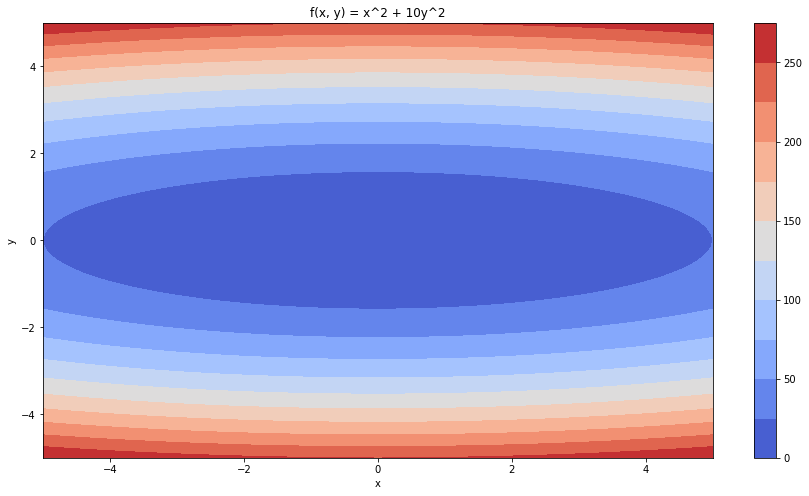

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
xlist = np.linspace(-5.0, 5.0, 100)
ylist = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = X**2 + 10*Y**2

cp = plt.contourf(X, Y, Z, 10, cmap = 'coolwarm')
plt.colorbar(cp, cmap = 'coolwarm')
plt.title('f(x, y) = x^2 + 10y^2')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
!pip install autograd

  Created wheel for autograd: filename=autograd-1.3-cp37-none-any.whl size=47996 sha256=5a5bde083281448ad6bccae9b39ad73f07e300791205de7a9464c84b70ac322c
  Stored in directory: C:\Users\brati\AppData\Local\pip\Cache\wheels\42\62\66\1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
Successfully built autograd


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [13]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [14]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

In [15]:
# It is known
minima = np.array([3., .5])

In [16]:
f(*minima)

0.0

In [17]:
minima_ = minima.reshape(-1, 1)
minima_

array([[3. ],
       [0.5]])

In [18]:
f(*minima_)

array([0.])

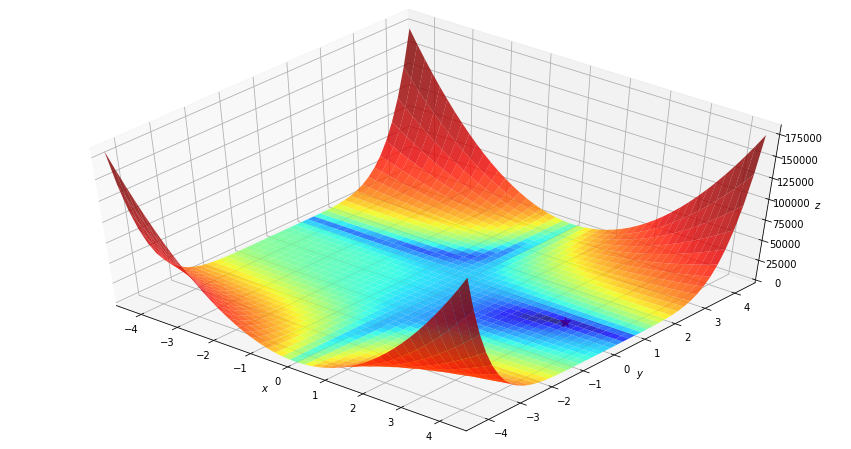

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [21]:
x0 = np.array([-2., 3.])

In [22]:
func = value_and_grad(lambda args: f(*args))

In [23]:
res = minimize(func, x0=x0, method='BFGS',
               jac=True, tol=1e-20, callback=print)

[-1.55327139  2.09416693]
[-3.36336408  1.18333637]
[-3.23472931  1.24392585]
[-3.23067403  1.24588333]
[-3.24098713  1.24455175]
[-3.25931052  1.24287055]
[-3.29351244  1.2401672 ]
[-3.35928555  1.23542433]
[-3.48793527  1.22682147]
[-3.73778841  1.21156819]
[-3.90740189  1.20358707]
[-4.11783669  1.19610798]
[-4.5367393  1.1827692]
[-5.27163364  1.15789588]
[-5.83477171  1.14835514]
[-6.32614734  1.13610237]
[-7.11049093  1.12113537]
[-7.52001668  1.11753583]
[-8.69736981  1.1011093 ]
[-9.03633723  1.09991323]
[-10.48387741   1.0852881 ]
[-10.57432224   1.08641297]
[-11.8126905    1.07748659]
[-12.47116395   1.07332108]
[-13.26244459   1.06940087]
[-14.5403009    1.06399873]
[-15.53465536   1.05961596]
[-16.47050231   1.05659927]
[-17.79973782   1.05296731]
[-18.51567089   1.05066936]
[-19.44507319   1.04828112]
[-20.70676486   1.04559319]
[-22.49926791   1.0421115 ]
[-24.57817055   1.03915977]
[-26.0197911    1.03670321]
[-26.89501967   1.03537365]
[-27.75024707   1.03431018]
[-28.8

[-6.29169963e+03  1.00015747e+00]
[-6.37293882e+03  1.00015547e+00]
[-6.41667479e+03  1.00015440e+00]
[-6.47371232e+03  1.00015304e+00]
[-6.55512690e+03  1.00015115e+00]
[-6.65891820e+03  1.00014876e+00]
[-6.72224548e+03  1.00014739e+00]
[-6.77923844e+03  1.00014613e+00]
[-6.82279856e+03  1.00014521e+00]
[-6.89543307e+03  1.00014369e+00]
[-6.93779489e+03  1.00014280e+00]
[-6.98034321e+03  1.00014193e+00]
[-7.03914532e+03  1.00014076e+00]
[-7.09498992e+03  1.00013964e+00]
[-7.15960085e+03  1.00013839e+00]
[-7.26479331e+03  1.00013637e+00]
[-7.34861878e+03  1.00013485e+00]
[-7.39983367e+03  1.00013390e+00]
[-7.45317074e+03  1.00013292e+00]
[-7.49468669e+03  1.00013219e+00]
[-7.54460811e+03  1.00013133e+00]
[-7.60761048e+03  1.00013023e+00]
[-7.68495390e+03  1.00012891e+00]
[-7.74023028e+03  1.00012801e+00]
[-7.80738605e+03  1.00012690e+00]
[-7.87728743e+03  1.00012577e+00]
[-7.94070245e+03  1.00012479e+00]
[-8.00203676e+03  1.00012382e+00]
[-8.04878086e+03  1.00012309e+00]
[-8.09894844e+

In [24]:
dict(res)

{'fun': 0.4521382869140481,
 'jac': array([ 4.45220186e-07, -6.14566790e+01]),
 'hess_inv': array([[1.36684339e+10, 9.70192276e+01],
        [9.70192276e+01, 6.88917754e-07]]),
 'nfev': 518,
 'njev': 518,
 'status': 1,
 'success': False,
 'message': 'Maximum number of iterations has been exceeded.',
 'x': array([-1.18399828e+04,  1.00008368e+00]),
 'nit': 400}

In [25]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

path_ = [x0]

res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))
dict(res)

{'fun': 0.4725355425930894,
 'jac': array([ 8.37232994e-04, -3.17685639e+00]),
 'nfev': 182,
 'njev': 822,
 'nhev': 0,
 'status': 3,
 'success': False,
 'message': "Warning: CG iterations didn't converge.  The Hessian is not positive definite.",
 'x': array([-73.96861788,   1.01324023]),
 'nit': 103}

In [26]:
path = np.array(path_).T
path.shape

(2, 104)

(-4.5, 4.5)

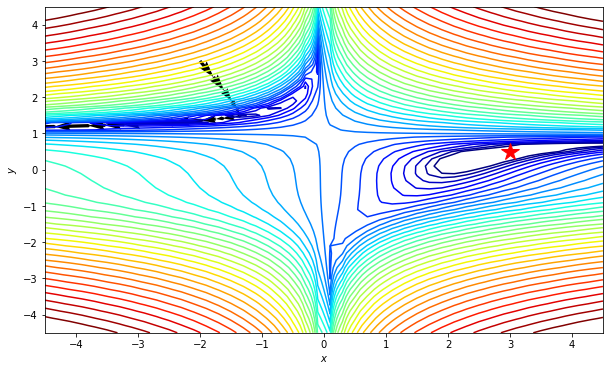

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))